In [2]:
import numpy as np
import h5py
from glob import glob 
from tqdm import tqdm
import os

from matplotlib import rc
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# #                                                                                                                                       
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})                                                                                             
mpl.rcParams['text.usetex'] = False
mpl.rcParams.update({'xtick.labelsize': 18})
mpl.rcParams.update({'ytick.labelsize': 18})
mpl.rcParams.update({'axes.labelsize': 18})
mpl.rcParams.update({'legend.frameon': False})
mpl.rcParams.update({'lines.linewidth': 2})

import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS)
hep.style.use("CMS")

from matplotlib.lines import Line2D

In [3]:
# function for getting histograms from observable values
def calc_hist(vals, bins=10, weights=None, density=True):
    
    if weights is None:
        weights = np.ones(vals.shape)
    
    # compute histogram
    hist, bins = np.histogram(vals, bins=bins, weights=weights)
    
    # compute which bins the values are in
    digits = np.digitize(vals, bins)

    # compute the errors per bin
    # note that lowest bin value that digitize returns is 1
    # hence the range in the following list comprehension should start at 1
    errs = np.asarray([np.linalg.norm(weights[digits==i]) for i in range(1, len(bins))])

    # handle normalization
    if density:
        binwidths = bins[1:] - bins[:-1]
        density_int = weights.sum() * binwidths # (bins[1] - bins[0])
        hist /= density_int
        errs /= density_int
        
    return hist, errs, bins

In [5]:
# get 2004 aleph measurement
# hepData = "/local/d1/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"
# hepData = "/global/cfs/cdirs/m3246/bnachman/LEP/aleph/HEPData-ins636645-v1-Table_54.csv"
hepData = "/home/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"

with open(hepData, 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

aleph_bins = 1 - np.append(1.0, hepdata[::-1,1])
aleph_midbins = (aleph_bins[1:] + aleph_bins[:-1])/2
aleph_thrust = hepdata[::-1,3]
aleph_thrust_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
assert np.all(aleph_bins[1:] == 1 - hepdata[::-1,1]) and np.all(aleph_bins[:-1] == 1 - hepdata[::-1,2])

aleph_log_bins = np.log(aleph_bins + np.exp(-8))
aleph_log_midbins = (aleph_log_bins[1:] + aleph_log_bins[:-1])/2
log_binwidths = aleph_log_bins[1:] - aleph_log_bins[:-1]
aleph_log_thrust = aleph_thrust * 0.01 / log_binwidths
aleph_log_thrust_errs = aleph_thrust_errs * 0.01 / log_binwidths

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [6]:
# dataProcessedDir = "/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/"
# dataProcessedDir = "/local/d1/badea/e+e-/aleph/data/processed/"
dataProcessedDir = "/home/badea/e+e-/aleph/data/processed/"

# data raw
data = np.load(os.path.join(dataProcessedDir, "data_vals_reco.npy"))
dpass = np.load(os.path.join(dataProcessedDir, "data_pass_reco.npy")).astype(bool)
print(data.shape, dpass.shape, dpass.sum())

# pythia 6 gen
gen = np.load(os.path.join(dataProcessedDir, "MC_vals_truth.npy"))
gpass = np.load(os.path.join(dataProcessedDir, "MC_pass_truth.npy")).astype(bool)
print(gen.shape, gpass.shape, gpass.sum())

# pythia 6 reco
reco = np.load(os.path.join(dataProcessedDir, "MC_vals_reco.npy"))
rpass = np.load(os.path.join(dataProcessedDir, "MC_pass_reco.npy")).astype(bool)
print(reco.shape, rpass.shape, rpass.sum())

(1365440,) (1365440,) 1326351
(973769,) (973769,) 973769
(973769,) (973769,) 751861


In [7]:
# define binning because used next
density = True
bins = aleph_log_bins # np.linspace(-8, np.log(0.5), 50+1)
bin_edges = bins
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
binwidths = bins[1:] - bins[:-1]

In [11]:
# unfolded results
# steps:
# 1. save all model evaluation weights rather than the finished histogram
# 2. histogram in here all distributions using the correct binning
# 3. plot nominal value
# 4. compute error bars
# 5. plot error bars

# path to unfolded results
# weightsDir = "/global/u1/b/badea/OmniFold/eval/weights/"
# weightsDir = "/local/d1/badea/e+e-/aleph/OmniFold/eval/weights"
weightsDir = "/home/badea/e+e-/aleph/OmniFold/eval/weights/"

paths = [
    ["bootstrap_sim_full", os.path.join(weightsDir, "boot_sim_n_40/*/*.h5")], # bootstrap sim full n=40
    ["bootstrap_data_full", os.path.join(weightsDir, "phys_weights_n_40/*/*.h5")], # bootstrap data full n=40
    ["ensemble", os.path.join(weightsDir, "redone_enemble_weights/*.h5")], # ensemble 40
    ["systematic", "/home/badea/e+e-/aleph/OmniFold/scripts/results/training-1edbafaa/*/omnifold_weights.h5"] # systematic variations
]

# loop over list, histogram, save
u = {}
for key, path in paths:
    fileList = glob(path)
    u[key] = {"counts":[], "errs":[]}
    for fName in tqdm(fileList):
        with h5py.File(fName, "r") as f:
            weights = np.array(f['weights'])
            # unfolded_counts, _ = np.histogram(np.log(1-gen[gpass]), bins=bins, weights = weights[gpass], density=density)
            counts, errs, _ = calc_hist(np.log(1-gen[gpass]), bins=bins, weights=weights[gpass], density=density)
            u[key]["counts"].append(counts)
            u[key]["errs"].append(errs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.66it/s]


In [13]:
# pick one value as the nominal
unfolded_counts = u["bootstrap_data_full"]["counts"][0]

# compute errors
errs = {}
for key, val in u.items():
    sd = np.std(val["counts"],axis=0)
    ave = np.mean(val["counts"],axis=0)
    sd_over_mean = sd/ave
    errs[key] = sd_over_mean
    
# add in quadrature
unfolded_errs = np.sqrt(np.sum(np.array(list(errs.values()))**2,0))
unfolded_errs += u["bootstrap_data_full"]["errs"][0]**2
unfolded_errs = np.sqrt(unfolded_errs)

# scale by central value
unfolded_errs *= unfolded_counts

In [14]:
# to-do: need to get this correction factor
# 06/23/24: AB believes we do not need this because we are reweighting straight to gen before
#           because in dataloader.py we use mc_gen = np.stack(MC["tgenBefore_thrust"]).flatten()
# corrs = genbhist/(genhist + 10**-50)

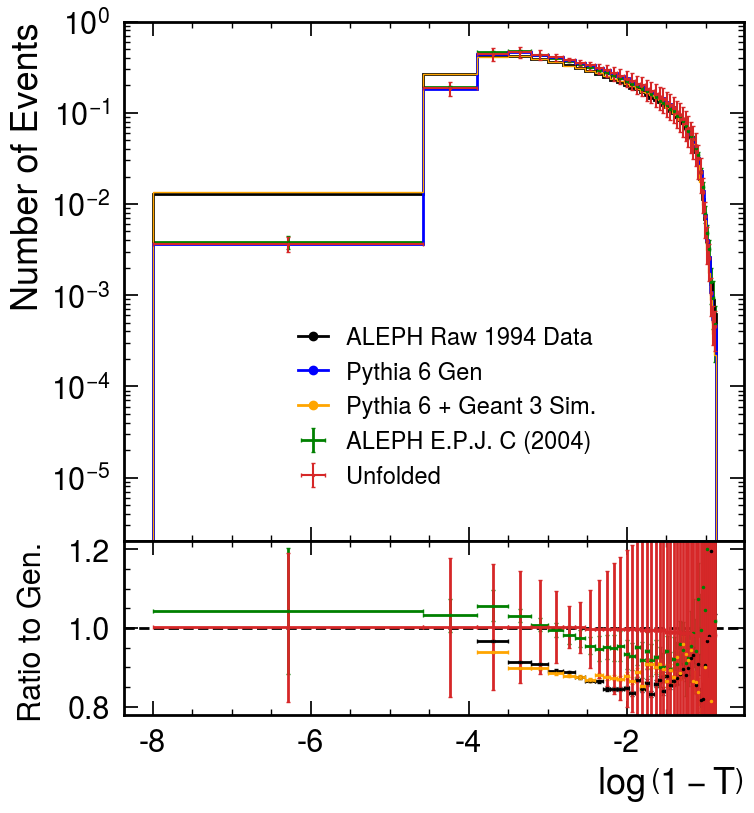

In [15]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,9))
plt.subplots_adjust(hspace=0)

# ALEPH 2004 measurement
ax1.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH E.P.J. C (2004)', 
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
aleph_raw_data_counts, _, _ = ax1.hist(np.log(1-data[dpass]), bins=bins, color='black', label='ALEPH Raw 1994 Data', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Gen
gen_counts, _, _ = ax1.hist(np.log(1-gen[gpass]), bins=bins, color='blue', label='Pythia 6 Gen', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Reco
reco_counts , _, _ = ax1.hist(np.log(1-reco[rpass]), bins=bins, color='orange', label='Pythia 6 + Geant 3 Sim.', histtype = 'step', density=density)

# Unfolded distribution
ax1.errorbar(midpoints, unfolded_counts, color='tab:red', label='Unfolded', xerr=binwidths/2, yerr=unfolded_errs, 
             fmt='o', lw=1.5, capsize=1.5, capthick=1, markersize=1.5)

ax1.legend()

# Bottom subplot (ratio plot)
ax2.axhline(y=1, color='black', linestyle='--')  # Adding a horizontal line at y=1 for reference

# calculate ratios
gen_hist_aleph_bins =  np.histogram(np.log(1-gen[gpass]), bins=bins, density=False)

# ALEPH 2004 measurement ratio
ax2.errorbar(aleph_log_midbins, aleph_log_thrust/(gen_counts+1e-50), xerr=log_binwidths/2, yerr=aleph_log_thrust_errs/(gen_counts + 10**-50),
             color='green', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
_, aleph_raw_data_errs, _ = calc_hist(np.log(1-data[dpass]), bins=bins, density=True)
ax2.errorbar(midpoints, aleph_raw_data_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, yerr=aleph_raw_data_errs / (gen_counts + 10**-50),
             color='black', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Pythia 6 Reco
_, reco_errs, _ = calc_hist(np.log(1-reco[rpass]), bins=bins, density=True)
ax2.errorbar(midpoints, reco_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, yerr=reco_errs / (gen_counts + 10**-50),
             color='orange', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Unfolded distribution
ax2.errorbar(midpoints, unfolded_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, yerr=unfolded_errs / (gen_counts + 10**-50),
             color='tab:red', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 22,
                     "pad"       : 10}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18}
ax1.tick_params(**tick_params_major)
ax1.tick_params(**tick_params_minor)
ax2.tick_params(**tick_params_major)
ax2.tick_params(**tick_params_minor)

# set limits
ax1.set_ylim(0.2*10**-5, 10**0)
# ax2.set_xlim(-10,0)
ax2.set_ylim(0.78,1.22)

# log scale
ax1.set_yscale("log")

# axis labels
ax1.set_ylabel("Number of Events") #r'Number of $\tilde{\eta}$ decays/Event')
ax2.set_ylabel("Ratio to Gen.", fontsize=22, labelpad=14)
ax2.set_xlabel(r'$\log\left(1-T\right)$')

# legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
for h in handles:
    try:
        new_handles.append(Line2D([], [], linestyle='-', marker='o', c=h.get_edgecolor()))
    except:
        new_handles.append(h)
            
ax1.legend(new_handles,
          labels,
          title="",
          title_fontsize="13",
          ncol=1,
          framealpha=0.0,
          prop={'size': 17},
          bbox_to_anchor=(0.35, 0.01, 0.45, 0.45), #(0.54, 0.45, 0.45, 0.5)
          handlelength=1.25)

# add text
# left, top, t = 0.07, 0.94, 0.06
# stamps = [
#     r"higgs portal, $pp \rightarrow h \rightarrow q_{d}q_{d} \; (q_{d} \rightarrow (dark) \; hadrons)$",
#     "arxiv:2103.01238",
#     r"$\mathit{m_{\tilde{\omega}}} = \mathit{m_{\tilde{\eta}}}$",
#     r"$c\tau = 30\; mm \times \left(\frac{5 \; GeV}{\mathit{m_{\tilde{\eta}}}}\right)^{7}$", #  # 5 \; GeV / \mathit{m_{\tilde{\eta}}}
#     r"$L_{xy} < 1000\; mm$",
#     r"$\mathrm{p_{T}}$ > 5 GeV, |$\eta$|<2.4",
# ]
# for i, stamp in enumerate(stamps):
#     ax1.text(left, top - i*t, stamp, fontsize=14, ha='left', va='top', transform=ax1.transAxes)

# save
# plt.savefig("number_of_decays.pdf", bbox_inches="tight")